### BART ridership between stops

Hello! This notebook is an attempt to visualize origin-destination ridership data for BART as edge widths on a graph of stopping patterns. The approach is full of assumptions, and some are wrong in one way or another. Feel free to suggest improvements or send a pull request.

- [GTFS feed](http://transitfeeds.com/p/bart/58/20161223)
- [2017 Monthly Ridership Reports](http://64.111.127.166/ridership/Ridership_March2017.xlsx)

In [1]:
from collections import defaultdict
from gtfslib.dao import Dao
from gtfslib.model import CalendarDate, Route
from itertools import tee
import networkx as nx
import nxpd
import pandas as pd
import utm

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def supersequence(x, y):
    """ True if and only if all elements in y occur in x in order (x is a supersequence of y)"""
    idx = 0
    try:
        for i in y:
            idx = x.index(i, idx)+1
    except ValueError as e:
        return False
    return True

In [2]:
od = pd.read_csv("./data/Ridership_March2017_Weekdays.csv",
                 index_col=0).T.loc

In [3]:
dao = Dao()
dao.load_gtfs("./data/BART-2016-12-23.zip")

In [4]:
def remap_stop_id(stop_id):
    # remap stop_ids to match O-D matrix keys
    return {'MCAR_S': 'MCAR', '19TH_N': '19TH'}.get(stop_id, stop_id)

patterns = set()
trip_counts = defaultdict(int)

fltr = (
    # pick trips scheduled for a specific date
    (CalendarDate.date=="2017-03-17")
    # skip airport connector trips
    & ~(Route.route_id=="19")
)
for trip in dao.trips(fltr=fltr):
    pattern = tuple(remap_stop_id(st.stop_id) for st in trip.stop_times)
    patterns.add(pattern)
    trip_counts[pattern] += 1

In [5]:
G = nx.DiGraph()
for pattern in patterns:
    for a, b in pairwise(pattern):
        G.add_edge(a, b)

In [6]:
for stop_id, data in G.nodes(data=True):
    data["label"] = dao.stop(stop_id).stop_name

for a, b, data in G.edges(data=True):
    data["riders"] = 0

for from_stop_id in G.nodes():
    for to_stop_id in G.nodes():
        if from_stop_id == to_stop_id:
            continue

        # Find all simple (no-repeated node) paths between source and target
        paths = list(map(tuple, nx.all_simple_paths(G, source=from_stop_id, target=to_stop_id)))

        path_patterns = defaultdict(list)
        for path in paths:
            # Find any stopping patterns that contain the path
            # These paths are not necessarily traversed by any trips
            # This is a simplifying assumption that ignores transfers
            for pattern in patterns:
                if supersequence(pattern, path):
                    path_patterns[path].append(pattern)

        available_trips = [sum(trip_counts[pattern] for pattern in path_patterns[path]) for path in paths]
        total_available_trips = float(sum(available_trips))

        # Distribute rider counts across edges based on
        # the proportion of trips for each pattern
        for i, path in enumerate(paths):
            if not available_trips[i]:
                continue

            odkey = (path[0], path[-1])
            total_riders_between_stops = int(od[odkey])
            pct_of_trips = available_trips[i] / total_available_trips
            riders_along_path = pct_of_trips * total_riders_between_stops

            # Add rider count to each edge of the path
            for a, b in pairwise(path):
                G[a][b]["riders"] += riders_along_path

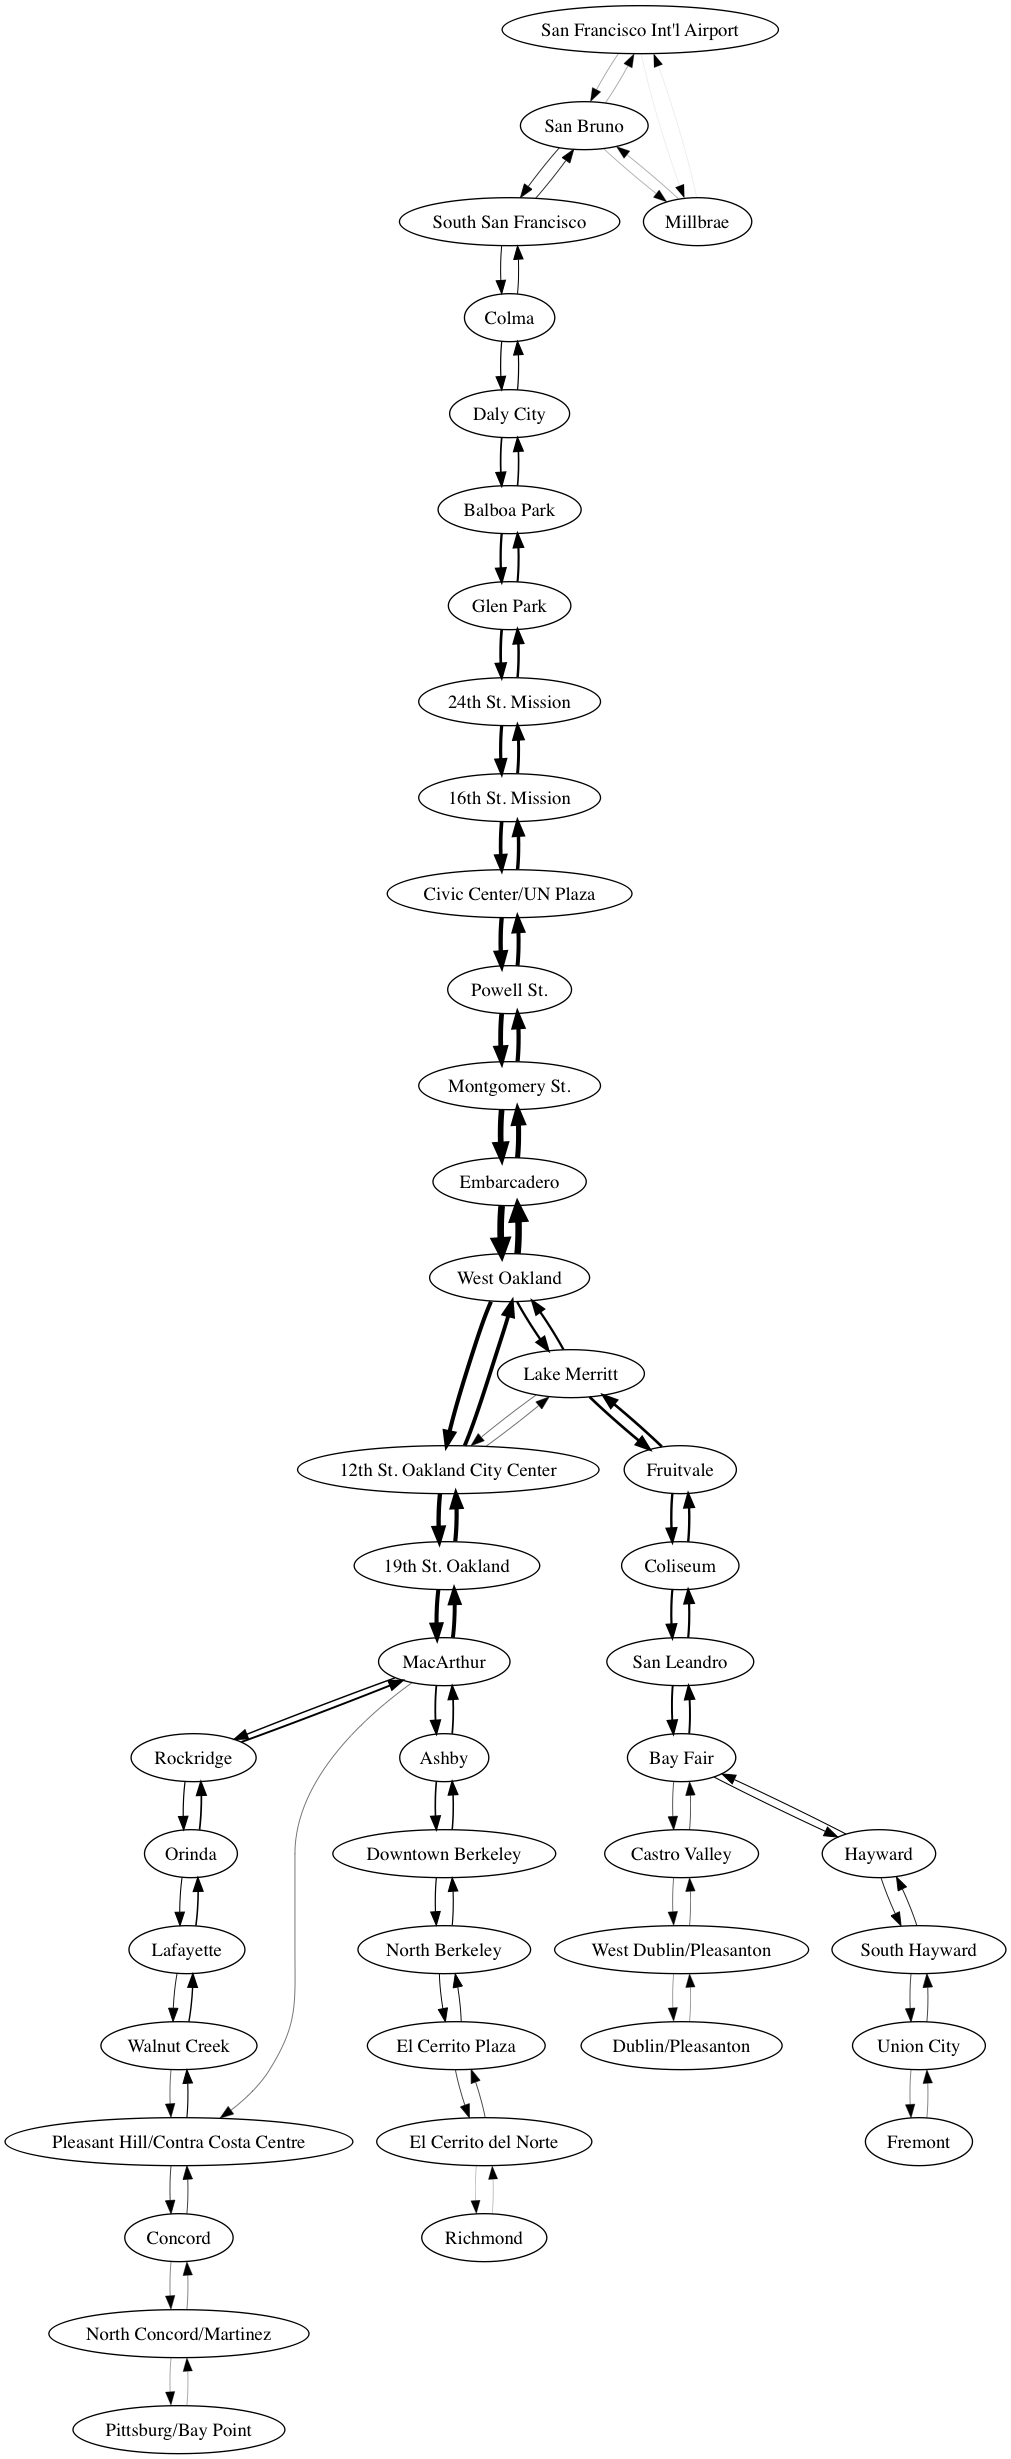

In [7]:
edges = list(G.edges(data=True))
riders = [d["riders"] for (a, b, d) in edges]

maxriders = float(max(riders))
penwidths = [5 * (r / maxriders) for r in riders]

for i, (a, b, d) in enumerate(edges):
    d["penwidth"] = penwidths[i]

nxpd.draw(G, show='ipynb')